Necessary Imports

In [159]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import math
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import top_k_accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

Load the Dataset

In [160]:
df = pd.read_csv("/content/nepali_sentences.csv")
faqs = df['Sentence'].astype(str).tolist()

Tokenize Text

In [161]:
# Initialize the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(faqs)  # We directly fit the tokenizer on the list
total_words = len(tokenizer.word_index) + 1  # +1 for the padding token

# Convert the text into sequences of tokens
input_sequences = []
for line in faqs:  # Loop over the list directly
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)


{1: 'म', 2: 'छ।', 3: 'चाहन्छु।', 4: 'धेरै', 5: 'नयाँ', 6: 'मेरो', 7: 'तपाईंको', 8: 'हामी', 9: 'एक', 10: 'के', 11: 'हाम्रो', 12: 'छ', 13: 'मलाई', 14: 'मनपर्छ।', 15: 'कस्तो', 16: 'छन्।', 17: 'गर्न', 18: 'मैले', 19: 'आज', 20: 'यो', 21: 'घुम्न', 22: 'लागि', 23: 'छु।', 24: 'हो', 25: 'जान', 26: 'र', 27: 'हो।', 28: 'सबै', 29: 'त्यो', 30: 'तपाईलाई', 31: 'गर्छु।', 32: 'घर', 33: 'काम', 34: 'पुस्तक', 35: 'जान्छु।', 36: 'उसको', 37: 'ठूलो', 38: 'राम्रो', 39: 'मद्दत', 40: 'फिल्म', 41: 'हेर्न', 42: 'स्कूलमा', 43: 'विद्यार्थी', 44: 'पढ्न', 45: 'सुरु', 46: 'दिन', 47: 'सिक्न', 48: 'समय', 49: 'तपाईंलाई', 50: 'उनी', 51: 'स्कूल', 52: 'बन्न', 53: 'रोचक', 54: 'परिवार', 55: 'फोन', 56: 'खाना', 57: 'छिट्टै', 58: 'जानेछौं।', 59: 'तपाईको', 60: 'मनपर्ने', 61: 'गीत', 62: 'साथीलाई', 63: 'भेट्न', 64: 'मनपर्छ', 65: 'रमाइलो', 66: 'हुनेछ।', 67: 'सबैभन्दा', 68: 'प्रिय', 69: 'खेल', 70: 'कहाँ', 71: 'कुरा', 72: 'गन्तव्य', 73: 'गरेको', 74: 'एकदम', 75: 'बस्छु।', 76: 'चाहन्छौं।', 77: 'हुँ।', 78: 'त्यहाँ', 79: 'बनाउन', 80: 'परि

In [192]:
import pickle

# Save the tokenizer to a file
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

print("Tokenizer saved successfully!")

Tokenizer saved successfully!


Pad sequences to have uniform length

In [162]:
max_sequence_len = max([len(seq) for seq in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

Split data into predictors (X) and label (y)

In [163]:
X = input_sequences[:, :-1]
y = input_sequences[:, -1]
y = to_categorical(y, num_classes=total_words)

Build the LSTM model

In [164]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len - 1))
model.add(LSTM(150))
model.add(Dense(total_words, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Compile the model

In [165]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Train the model

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

# Train the model (if not already trained)
history = model.fit(X_train, y_train, epochs=20, verbose=1,validation_split=0.2)
# Save the model after training
model.save('nepali_language_model.h5')

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.0424 - loss: 5.4051 - val_accuracy: 0.1312 - val_loss: 4.5808
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.1971 - loss: 4.0398 - val_accuracy: 0.4019 - val_loss: 2.6683
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5159 - loss: 2.2098 - val_accuracy: 0.7084 - val_loss: 1.4380
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7527 - loss: 1.2372 - val_accuracy: 0.8091 - val_loss: 0.8821
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7954 - loss: 0.8330 - val_accuracy: 0.8110 - val_loss: 0.6970
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.7879 - loss: 0.7181 - val_accuracy: 0.8156 - val_loss: 0.6241
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7926 - loss: 0.6441 - val_accuracy: 0.8078 - val_loss: 0.6023
Epoch 8/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7995 - loss: 0.6137 - val_accu

In [167]:
# Load the model before making predictions
model = load_model('nepali_language_model.h5')

Next Word Prediction Function

In [168]:
#Version 1
def predict_next_word(model, tokenizer, text, max_sequence_len):
    # Start with the seed text
    token_list = tokenizer.texts_to_sequences([text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

    # Predict the next word
    predicted_probs = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted_probs)

    # Map the predicted index back to the corresponding word
    predicted_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            predicted_word = word
            break

    return predicted_word


In [169]:
#Version 2
def predict_next_words(model, tokenizer, text, max_sequence_len, top_n=3):
    # Start with the seed text
    token_list = tokenizer.texts_to_sequences([text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

    # Predict the next word probabilities
    predicted_probs = model.predict(token_list, verbose=0)

    # Get the indices of the top N words with the highest probability
    predicted_word_indices = np.argsort(predicted_probs[0])[::-1][:top_n]

    # Map the predicted indices back to words
    predicted_words = []
    for index in predicted_word_indices:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                predicted_words.append(word)
                break

    return predicted_words


Real-time Prediction

In [170]:
# Version 1
def predict_while_typing():
    sentence = ""
    print("Start typing (Type 'q' to quit): ")

    while True:
        # Take the user input (next word)
        input_text = input("Type next word: ")

        # Exit condition
        if input_text.lower() == 'q':
            break

        # Add typed input to the sentence
        sentence += " " + input_text

        # Predict the next word based on the current sentence
        predicted_word = predict_next_word(model, tokenizer, sentence, max_sequence_len)

        # Add predicted word to the sentence
        sentence += " " + predicted_word

        # Display the current sentence (typed + predicted)
        print(f"Current sentence: {sentence}")

# Run the real-time prediction
predict_while_typing()


Start typing (Type 'q' to quit): 
Type next word: q


In [191]:
#Version 2
def predict_while_typing():
    sentence = ""
    print("Start typing (Type 'q' to quit): ")

    while True:
        # Take the user input (next word)
        input_text = input("Type next word: ")

        # Exit condition
        if input_text.lower() == 'q':
            break

        # Add typed input to the sentence
        sentence += " " + input_text

        # Predict the next words based on the current sentence
        predicted_words = predict_next_words(model, tokenizer, sentence, max_sequence_len, top_n=3)

        # Display the predicted words and ask for the user's choice
        print(f"Predicted words:")
        for i, word in enumerate(predicted_words, 1):
            print(f"{i}. {word}")

        # Ask the user to select a word
        try:
            choice = int(input(f"Choose a word by number (1, 2, or 3): "))

            if choice not in [1, 2, 3]:
                print("Invalid choice. Please choose 1, 2, or 3.")
                continue  # Skip this loop iteration and let the user try again

            # Add the chosen word to the sentence
            sentence += " " + predicted_words[choice - 1]

        except ValueError:
            print("Please enter a valid number (1, 2, or 3).")
            continue  # Skip this loop iteration and let the user try again

        # Display the current sentence (typed + predicted)
        print(f"Current sentence: {sentence}")

# Run the real-time prediction
predict_while_typing()


Start typing (Type 'q' to quit): 
Type next word: तपाईंको सहकार्यले
Predicted words:
1. हाम्रो
2. सबै
3. काम
Choose a word by number (1, 2, or 3): 1
Current sentence:  तपाईंको सहकार्यले हाम्रो
Type next word: काम
Predicted words:
1. सफल
2. बनाउन
3. सफलता
Choose a word by number (1, 2, or 3): 1
Current sentence:  तपाईंको सहकार्यले हाम्रो काम सफल
Type next word: बनाउन मद्दत
Predicted words:
1. गर्‍यो।
2. मद्दत
3. पुर्यायो।
Choose a word by number (1, 2, or 3): 1
Current sentence:  तपाईंको सहकार्यले हाम्रो काम सफल बनाउन मद्दत गर्‍यो।
Type next word: q


Necessary Plots

Loss Curve

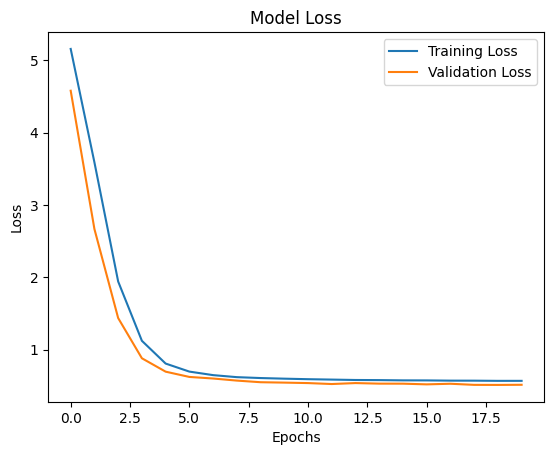

In [178]:
# Assuming 'history' contains the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Accuracy Curve

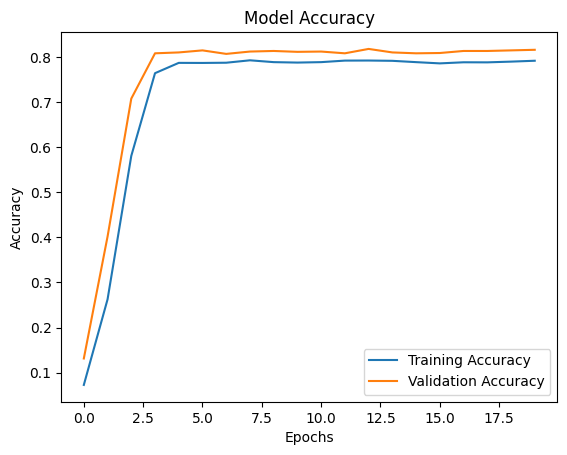

In [179]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Model Architecture

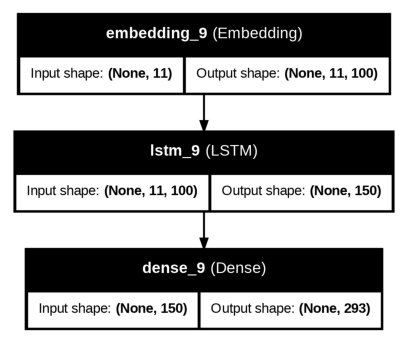

In [180]:
# Save the model architecture as an image file
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Optional: To display the model architecture with a custom size
img = plt.imread('model_architecture.png')

# Create a figure with custom size
plt.figure(figsize=(5, 5))  # Adjust width and height here
plt.imshow(img)
plt.axis('off')  # Hide axes for better clarity
plt.show()


Metrics

In [184]:

# Assuming you have a tokenizer already fitted
# Reverse the word index to create idx_to_word mapping
idx_to_word = {index: word for word, index in tokenizer.word_index.items()}

# 1. Calculate Perplexity
def calculate_perplexity(model, X_test, y_test):
    # Calculate the loss from the model (categorical cross-entropy)
    loss, _ = model.evaluate(X_test, y_test, verbose=0)  # Only extract the first element, which is the loss

    # Perplexity is the exponential of the loss
    perplexity = math.exp(loss)
    return perplexity

# 2. Calculate BLEU Score (using NLTK)
def calculate_bleu_score(y_true, y_pred, idx_to_word):
    # Convert one-hot encoded y_true to word indexes and then to words
    y_true_words = [[idx_to_word[index]] for index in np.argmax(y_true, axis=1)]  # List of lists for ground truth
    y_pred_words = [idx_to_word[index] for index in np.argmax(y_pred, axis=1)]  # List for predictions

    # Convert predictions into a list of lists for the BLEU score calculation
    y_pred_words = [y_pred_words[i:i+1] for i in range(len(y_pred_words))]  # Convert into a list of lists

    # Calculate BLEU score (for simplicity, we calculate 1-gram BLEU)
    bleu_score = corpus_bleu(y_true_words, y_pred_words)
    return bleu_score

# 3. Precision, Recall, F1 Score, and Accuracy (already discussed)
# Ensure y_pred is in class indices (e.g., [0, 1, 2, ...] instead of probabilities)
if len(y_pred.shape) > 1:  # If y_pred is 2D (probabilities), we need to use np.argmax to get class indices
    y_pred_class = np.argmax(y_pred, axis=1)
else:  # If y_pred is already class indices (1D), use it directly
    y_pred_class = y_pred

# Ensure y_test is also in class indices (in case it's one-hot encoded)
if len(y_test.shape) > 1:  # If y_test is 2D (one-hot), convert to class indices
    y_true_class = np.argmax(y_test, axis=1)
else:  # If y_test is already class indices (1D), use it directly
    y_true_class = y_test

# Calculate Precision, Recall, F1 Score, and Accuracy
precision = precision_score(y_true_class, y_pred_class, average='weighted')
recall = recall_score(y_true_class, y_pred_class, average='weighted')
f1 = f1_score(y_true_class, y_pred_class, average='weighted')
accuracy = accuracy_score(y_true_class, y_pred_class)

perplexity = calculate_perplexity(model, X_test, y_test)

# Output the results
print(f"Perplexity: {perplexity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Perplexity: 1.7528
Precision: 0.7893
Recall: 0.7874
F1-Score: 0.7705
Accuracy: 0.7874


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


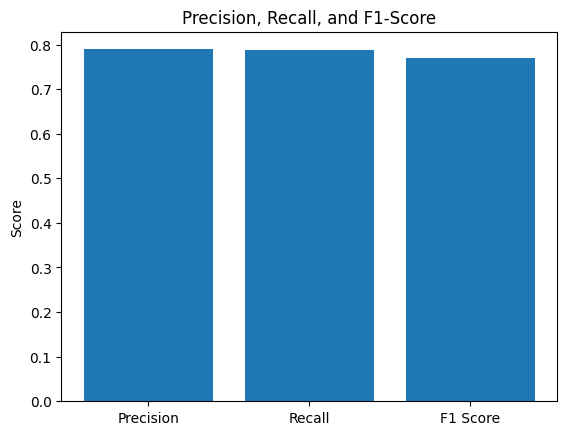

In [185]:


precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

metrics = ['Precision', 'Recall', 'F1 Score']
values = [precision, recall, f1]

plt.bar(metrics, values)
plt.title('Precision, Recall, and F1-Score')
plt.ylabel('Score')
plt.show()
